In [1]:
# https://github.com/ecsplendid/nlp-skipgram-talk/blob/master/SkipGram%20NegativeSampling-IMDB.ipynb

In [2]:
from pickle import load
from numpy import array, zeros
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.sequence import skipgrams
from sklearn.metrics.pairwise import cosine_distances
import numpy as np
import matplotlib.pyplot as plt

/home/viki/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# Load data set
raw_x, raw_y = load(open("/home/viki/Desktop/flipkart.pkl", 'rb'))

In [4]:
# Remove Empty set if any
count = 0
data_x = []
data_y = []
for idx in range(len(raw_x)):
    if not raw_x[idx] == []:
        data_x.append(raw_x[idx])
        data_y.append(raw_y[idx])

# Check total number of stars
ratings = {}
for i in data_y:
    if not ratings.get(i):
        ratings[i] = 1
        continue
    else:
        ratings[i] += 1
print("{ratings: counts} -->", ratings)

{ratings: counts} --> {'4': 7300, '5': 15715, '2': 1457, '1': 3268, '3': 2836}


In [5]:
# Read vocabulary  in corpus
vocab = []
for seq in data_x:
    for i in seq: 
        if i in vocab:
            continue
        vocab.append(i)
vocab_size = len(vocab)
print("size of vocabulary, ", vocab_size)

size of vocabulary,  7426


In [6]:
# Check vocab has duplication
vocab_checking = []
for v in vocab:
    if v in vocab_checking:
        print(v, "is duplicated")
        break
    vocab_checking.append(v)
vocab_checking = None

In [7]:
# Create word to index, index to word
word_to_index = {word:idx for idx, word in enumerate(vocab)}
index_to_word = {idx: word for word, idx in word_to_index.items()}

In [8]:
# sentence to sequence of integers
seq_x = [ list(map(word_to_index.get, i)) for i in data_x ]

In [9]:
sliding_window = 1
negative_sampling = 0.8
# Count outputs size of skipgrams
# s = (len(embedding) * (ws*2))-(ws*(ws+1))
# s = int( s + s*ns )
# skipgrams_count = 0
# tokens = 0
# for i in seq_x:
#     tokens += len(i)
#     s = (len(i) * (sliding_window*2)) - (sliding_window*(sliding_window+1))
#     s = int(s + s*negative_sampling)
#     skipgrams_count += s
# print("Totally", skipgrams_count, "skipgrams are there for", tokens, "words in corpus")

In [10]:
# Initialize words, context, output with zeros 
words = []
context = []
y = []

for seq in seq_x:
    ip, op = skipgrams(sequence=seq, vocabulary_size=vocab_size, window_size=sliding_window, negative_samples=negative_sampling)
    for i in range(len(ip)):
        words.append(ip[i][0])
        context.append(ip[i][1])
        y.append(op[i])
print("Totally", len(words), "skipgrams are there")

Totally 417738 skipgrams are there


In [11]:
# Verification
print("Word + Context = 0/1 --> ", [(index_to_word[i], index_to_word[j], [k]) for i,j,k in zip(words, context, y)][200:300])

Word + Context = 0/1 -->  [('good', 'ok', [1]), ('breaks', 'eat', [0]), ('durability', 'giftted', [0]), ('yet', 'dameged', [0]), ('good', 'yet', [1]), ('good', 'range', [1]), ('difficult', 'brilliant', [0]), ('breaks', 'palstic', [1]), ('yet', 'cancelling', [1]), ('difficult', 'easily', [1]), ('easily', 'lucky', [0]), ('good', 'grade', [0]), ('price', 'reliability', [0]), ('good', 'price', [1]), ('cancelling', 'noise', [1]), ('ok', 'good', [1]), ('ok', 'sound', [1]), ('carry', 'difficult', [1]), ('carry', 'attractions', [0]), ('carry', 'mistake', [0]), ('sound', 'durability', [1]), ('cancelling', 'yet', [1]), ('difficult', 'curve', [0]), ('sound', 'ok', [1]), ('good', 'wh', [0]), ('palstic', 'breaks', [1]), ('yet', 'early', [0]), ('carry', 'noise', [1]), ('palstic', 'durability', [1]), ('palstic', 'dumb', [0]), ('difficult', 'carry', [1]), ('yet', 'good', [1]), ('good', 'repeat', [0]), ('durability', 'palstic', [1]), ('good', 'overshadows', [0]), ('sound', 'notjinh', [0]), ('noise', 'c

In [12]:
onehot = OneHotEncoder(n_values=vocab_size)

def batcher(seq, batch_size):
    return (seq[pos:pos+batch_size] for pos in range(0, len(seq), batch_size))

def getBatch(w, c, y, batch_size):
    while 1:
        batches = batcher(range(len(words)), batch_size)

        for batch in batches:
            w_one_hot = onehot.fit_transform(np.array(list(w[i] for i in batch)).reshape(-1, 1)).todense()
            c_one_hot = onehot.fit_transform(np.array(list(c[i] for i in batch)).reshape(-1, 1)).todense()
            y_one_hot = np.array(list(y[i] for i in batch))
            
            yield ([w_one_hot,c_one_hot], y_one_hot)

batch_size = 1000
gen = getBatch(words, context, y, batch_size)

In [13]:
dimensions = 300

from keras.layers import Activation, dot, Reshape, Input, Dense
from keras.models import Model

input_word = Input(shape=(vocab_size,))
input_context = Input(shape=(vocab_size,))

dense_word = Dense(300)(input_word)
dense_context = Dense(300)(input_context)

dott = dot([dense_word, dense_context], 1)
reshape = Reshape((1,), input_shape=(1, 1))(dott)
output = Activation('sigmoid')(reshape)

model = Model(inputs=[input_word, input_context], outputs=[output])
model.compile(loss='binary_crossentropy', optimizer='adam')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 7426)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 7426)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 300)          2228100     input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 300)          2228100     input_2[0][0]                    
__________________________________________________________________________________________________
dot_1 (Dot

In [14]:
# from keras.utils import plot_model
# plot_model(model, to_file='sg-softmax.png')

In [15]:
%%time
steps_perepoch = int(len(words)/batch_size)
print("Steps per epoch: %d" % steps_perepoch)

history = model.fit_generator(gen, steps_per_epoch=steps_perepoch, epochs=5)

Steps per epoch: 417
Epoch 1/5
417/417 [==============================] - 125s 301ms/step - loss: 0.3715
Epoch 2/5
417/417 [==============================] - 122s 293ms/step - loss: 0.2934
Epoch 3/5
417/417 [==============================] - 131s 314ms/step - loss: 0.2825
Epoch 4/5
417/417 [==============================] - 127s 304ms/step - loss: 0.2683
Epoch 5/5
417/417 [==============================] - 136s 326ms/step - loss: 0.2482
CPU times: user 34min 6s, sys: 2min 3s, total: 36min 9s
Wall time: 10min 41s


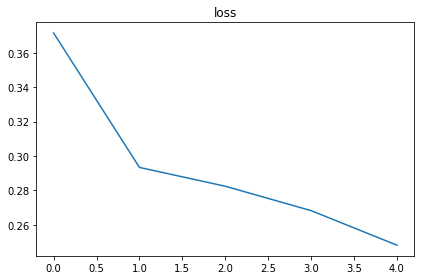

In [16]:
plt.plot(history.history['loss'])
plt.title('loss')
plt.tight_layout()
plt.show()

In [17]:
W, b = model.layers[2].get_weights()

In [18]:
embedding_layer = {}
for i in vocab:
    embedding_layer[i] = onehot.fit_transform(word_to_index[i]).todense()*W +b
print(embedding_layer['bass'])

[[ 0.01082266  0.08939599  0.13700417  0.05659332 -0.03455525  0.05542785
   0.06687147 -0.06519829  0.09480326 -0.08094492  0.06451854 -0.02474886
   0.06628592  0.04415993 -0.09964287 -0.11411594 -0.07787927 -0.07261389
   0.11265744 -0.03401594  0.09422398 -0.10090139 -0.04462065  0.06526309
  -0.12552607 -0.05706076 -0.11594392  0.12926401 -0.1245788   0.04970425
  -0.04287493 -0.05608106 -0.11694035 -0.03745536 -0.07070533 -0.04881976
   0.11900918 -0.06417853 -0.05247302  0.05128114 -0.03933613  0.05900391
  -0.05033375 -0.16682482 -0.06400925 -0.08984563  0.08366995 -0.06624165
   0.03351696  0.17527473 -0.07594745 -0.05447282  0.12666867 -0.12904482
   0.04793499  0.09607318 -0.07769022  0.0690478  -0.08830765  0.10003887
   0.04793111  0.13584991  0.10016608  0.08493786  0.03822772  0.04243951
   0.17642617  0.18900184 -0.06523384  0.07807607 -0.03213592 -0.06177717
  -0.07203411 -0.03552999  0.09654771 -0.04509222 -0.06549631  0.1156326
  -0.13045116  0.08461596 -0.0828656   

In [50]:
test_words = ['connector', 'bass', 'quality',  'sound', 'booster', 'comparision', 'price', 'nice', 'worthy', 'beats']

closest_10_words = {}

for test_word in test_words:
    test_word_embedding = embedding_layer[test_word]
    distances = []
    for i in vocab:
        target_word_embedding = embedding_layer[i]
        if i == test_word:
            continue        
        distances.append((cosine_distances(test_word_embedding, target_word_embedding), i))
    closest_10_words[test_word] = [w[1] for w in sorted(distances, reverse=True)[0:10]]

In [51]:
closest_10_words

{'bass': ['establishment',
  'puts',
  'ʙᴀss',
  'bahot',
  'wondering',
  'trebble',
  'hip',
  'exchangable',
  'besttt',
  'plugging'],
 'beats': ['establishment',
  'puts',
  'ʙᴀss',
  'bahot',
  'trebble',
  'besttt',
  'exchangable',
  'hip',
  'tottally',
  'dekho'],
 'booster': ['establishment',
  'quality',
  'sound',
  'product',
  'good',
  'money',
  'puts',
  'nice',
  'wondering',
  'trebble'],
 'comparision': ['establishment',
  'puts',
  'ʙᴀss',
  'bahot',
  'wondering',
  'trebble',
  'hip',
  'exchangable',
  'besttt',
  'plugging'],
 'connector': ['quality',
  'sound',
  'good',
  'establishment',
  'product',
  'nice',
  'money',
  'value',
  'awesome',
  'price'],
 'nice': ['establishment',
  'dekho',
  'bahot',
  'ʙᴀss',
  'tottally',
  'exchangable',
  'jhabua',
  'hip',
  'sᴏᴜɴᴅs',
  'vangi'],
 'price': ['establishment',
  'ʙᴀss',
  'wrapped',
  'dekho',
  'besttt',
  'colored',
  'bahot',
  'mthe',
  'tottally',
  'hip'],
 'quality': ['establishment',
  'wrappe